
Off-Ball Rating (OffBR) Calculation and Analysis

This notebook computes off-ball ratings for soccer players using tracking data:
1. Import libraries and load tracking data
2. Calculate Option Creation Rating (OCR) - offensive movement quality
3. Calculate Space Control Rating (SCR) - defensive positioning quality
4. Merge OCR and SCR into combined OffBR metric
5. Enrich data with player metadata (name, position, team, match outcome)
6. Save outputs (CSV and time-series pickle)
7. Batch process multiple matches (optional)
8. Load all match outputs (the ten provided matches are already treated and outputs saved)
9. Validate tactical coherence by position group
10. Analyze temporal evolution patterns

In [4]:
import pickle
import os
import pandas as pd

import src.config as config
from src.data_loader import load_and_process_tracking_df, load_all_matches_outputs
from src.offense_rating import OffenseRating
from src.defense_rating import DefenseRating

from src.analyze_offbr_outputs import add_metatdata_to_off_ball_rating, analyze_temporal_evolution, validate_tactical_coherence

#### load and process the match tracking data

In [5]:
match_id = 1886347
tracking_df = load_and_process_tracking_df(match_id)

Loading tracking data from skillcorner for match 1886347...
Converting tracking data in OffBR calculation format. This might take up to 20 seconds...
Processing 31522 frames...


31522it [00:38, 816.33it/s] 


#### calculate the two components of the Off Ball Rating 
1. option creation rating (ocr)
2. space control rating

In [6]:
# ocr
offense_rating = OffenseRating(config.FIELD_LENGTH)
ocr_df, ocr_seq = offense_rating.get_ocr(tracking_df)

Calculating Option Creation Rating (OCR) for all players at a 2-second interval...


100%|██████████| 1576/1576 [00:29<00:00, 53.02it/s]


In [7]:
ocr_df.head()

,player_id,team_id,avg_option_creation_rating
0,38673,4177,0.020570
1,51713,4177,0.029468
2,50951,4177,0.029131
3,50978,1805,0.025804
4,133498,4177,0.033325


In [8]:
# scr
defense_rating = DefenseRating(config.FIELD_LENGTH, config.FIELD_WIDTH)
scr_df, scr_seq = defense_rating.get_scr(tracking_df)

Calculating Space Control Rating (SCR) for all players at a 1-second interval...


100%|██████████| 3152/3152 [01:38<00:00, 32.05it/s]


In [9]:
scr_df.head()

,player_id,team_id,avg_zone_coverage,avg_pass_line_blocking,avg_space_control_rating
0,38673,4177,0.016263,0.061938,0.039100
1,51713,4177,0.013537,0.028701,0.021119
2,50951,4177,0.015676,0.055609,0.035643
3,133498,4177,0.012417,0.015127,0.013772
4,33697,4177,0.033906,0.014055,0.023981


In [10]:
# merge the outputs
# dataframe
off_ball_rating_df = ocr_df.merge(scr_df.drop(columns=['team_id']), on=['player_id'])

# sequence
off_ball_rating_seq = ocr_seq
for player_id in scr_seq:
    for key in scr_seq[player_id]:
        off_ball_rating_seq[player_id][key] = scr_seq[player_id][key]

In [11]:
#add player metadata in outputs (useful for analysis): team_name, outcome (W/D/L), player_name, position
off_ball_rating_df = add_metatdata_to_off_ball_rating(off_ball_rating_df, match_id)

In [12]:
off_ball_rating_df.head()

,player_id,player_name,position,position_group,playing_time,team_name,match_outcome,team_id,avg_option_creation_rating,avg_zone_coverage,avg_pass_line_blocking,avg_space_control_rating
0,38673,Guillermo Luis May Bartesaghi,Center Forward,Center Forward,86.65,Auckland FC,W,4177,0.020570,0.016263,0.061938,0.039100
1,51713,Callan Elliot,Right Back,Full Back,98.40,Auckland FC,W,4177,0.029468,0.013537,0.028701,0.021119
2,50951,Jake Brimmer,Center Forward,Center Forward,77.91,Auckland FC,W,4177,0.029131,0.015676,0.055609,0.035643
3,50978,Callum Timmins,Left Defensive Midfield,Midfield,86.26,Newcastle United Jets FC,L,1805,0.025804,0.014485,0.041669,0.028077
4,133498,Francis De Vries,Left Back,Full Back,98.40,Auckland FC,W,4177,0.033325,0.012417,0.015127,0.013772


#### save the merged outputs

In [13]:
os.makedirs(f"outputs/data/match_{match_id}", exist_ok=True)
off_ball_rating_df.to_csv(f"outputs/data/match_{match_id}/OffBR.csv", index=False)
with open(f"outputs/data/match_{match_id}/OffBR_seq.pickle", 'wb') as f:
    pickle.dump(off_ball_rating_seq, f)

#### loop if you want to run calculation on multiple matches

We've already run the calculation for all the 10 matches provided and stored all the outputs so you can skip this step and directly go the outputs analysis

In [ ]:
match_ids = os.listdir("data")
match_ids = [int(mid.split("_")[-1]) for mid in match_ids if mid.startswith("match_")]
print("Total matches:", len(match_ids))

for count, match_id in enumerate(match_ids):
    print(f"match {count+1}/{len(match_ids)}")
    tracking_df = load_and_process_tracking_df(match_id)

    offense_rating = OffenseRating(config.FIELD_LENGTH)
    ocr_df, ocr_seq = offense_rating.get_ocr(tracking_df)

    defense_rating = DefenseRating(config.FIELD_LENGTH, config.FIELD_WIDTH)
    scr_df, scr_seq = defense_rating.get_scr(tracking_df)

    off_ball_rating_df = ocr_df.merge(scr_df.drop(columns=['team_id']), on=['player_id'])
    off_ball_rating_seq = ocr_seq
    for player_id in scr_seq:
        for key in scr_seq[player_id]:
            off_ball_rating_seq[player_id][key] = scr_seq[player_id][key]

    off_ball_rating_df = add_metatdata_to_off_ball_rating(off_ball_rating_df, match_id)

    # save outputs
    os.makedirs(f"outputs/data/match_{match_id}", exist_ok=True)
    off_ball_rating_df.to_csv(f"outputs/data/match_{match_id}/OffBR.csv", index=False)
    with open(f"outputs/data/match_{match_id}/OffBR_seq.pickle", 'wb') as f:
        pickle.dump(off_ball_rating_seq, f)

### OffBR Analysis 

- A suite of analysis to access the relevancy of the metric

In [3]:
# Load your match outputs
match_dfs = {int(m.split('_')[1]): pd.read_csv(f'outputs/data/{m}/OffBR.csv') for m in os.listdir("outputs/data") if m.startswith("match_")}
match_seqs = {int(m.split('_')[1]): pickle.load(open(f'outputs/data/{m}/OffBR_seq.pickle', 'rb')) for m in os.listdir("outputs/data") if m.startswith("match_")}
len(match_dfs), len(match_seqs)

(10, 10)

In [4]:
combined_df = load_all_matches_outputs(match_dfs)

1. Tactical coherence analysis

Here we analyze the distribution of the OffBR values per position group across the 10 A-league matches

VALIDATION 1: TACTICAL COHERENCE

📊 Average Ratings by Position Group:
                 avg_option_creation_rating                \
                                       mean     std count   
position_group                                              
Center Forward                       0.0195  0.0071    48   
Central Defender                     0.0179  0.0063    54   
Full Back                            0.0219  0.0069    47   
Midfield                             0.0276  0.0078    75   
Other                                0.0082  0.0048    20   
Wide Attacker                        0.0219  0.0067    65   

                 avg_space_control_rating                
                                     mean     std count  
position_group                                           
Center Forward                     0.0362  0.0118    48  
Central Defender                   0.0255  0.0114    54  
Full Back                          0.0195  0.0072    47  
Midfield                       

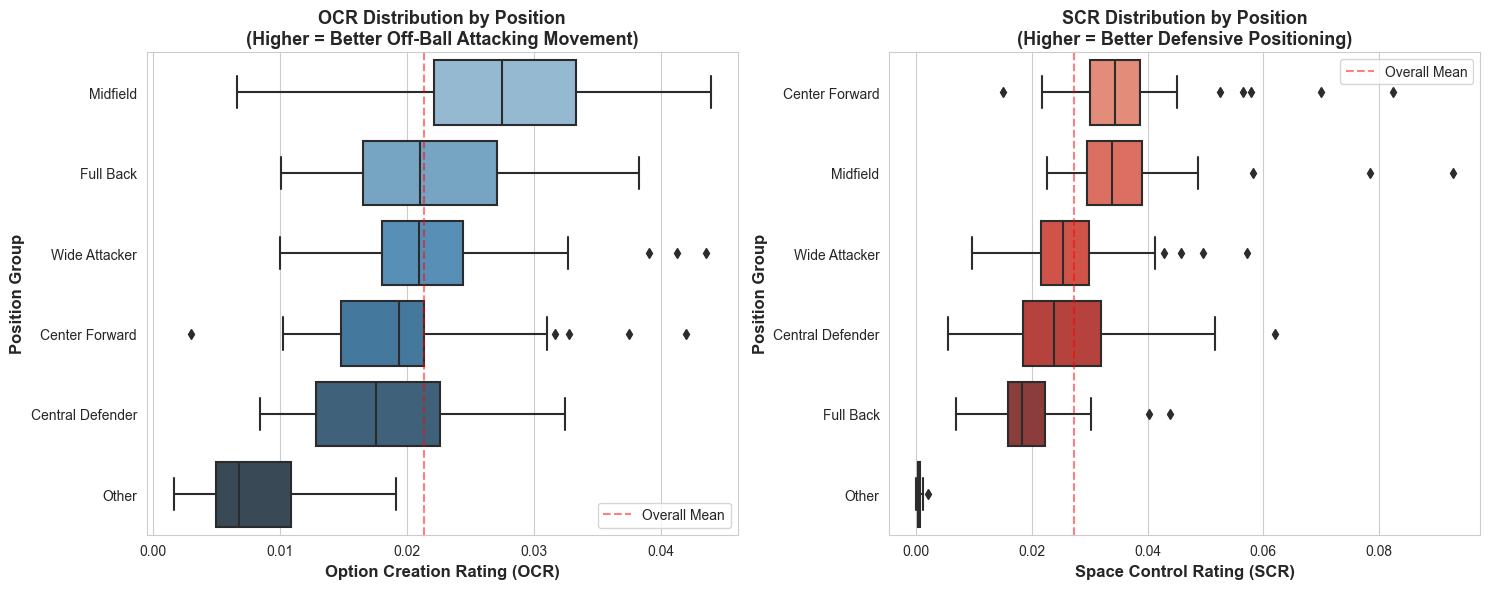

In [5]:
tactical_coherence = validate_tactical_coherence(combined_df)

2. Temporal evolution analysis

Here we analyze the temporal evolution of OffBR for selected players across all matches. The idea is to track how the off ball activity changes over time and identity any fatigue patterns


VALIDATION 2: TEMPORAL EVOLUTION (FATIGUE ANALYSIS)

📈 Analyzing OCR temporal patterns...

📊 Average OCR by Match Period:
  0-25%: 0.0221 (±0.0111)
  25-50%: 0.0214 (±0.0105)
  50-75%: 0.0206 (±0.0091)
  75-100%: 0.0208 (±0.0109)

📊 Average SCR by Match Period:
  0-25%: 0.0282 (±0.0168)
  25-50%: 0.0261 (±0.0161)
  50-75%: 0.0272 (±0.0163)
  75-100%: 0.0278 (±0.0171)

🔬 Temporal Trend Analysis:
  OCR trend: slope=-0.000472, pearson_corr=-0.891
  SCR trend: slope=-0.000014, pearson_corr=-0.020

✅ Visualization saved: outputs/plots/temporal_evolution_analysis.png

💡 INTERPRETATION:
  • OCR decreases over match duration (slope=-0.000472)
  • SCR remains relatively stable throughout the match


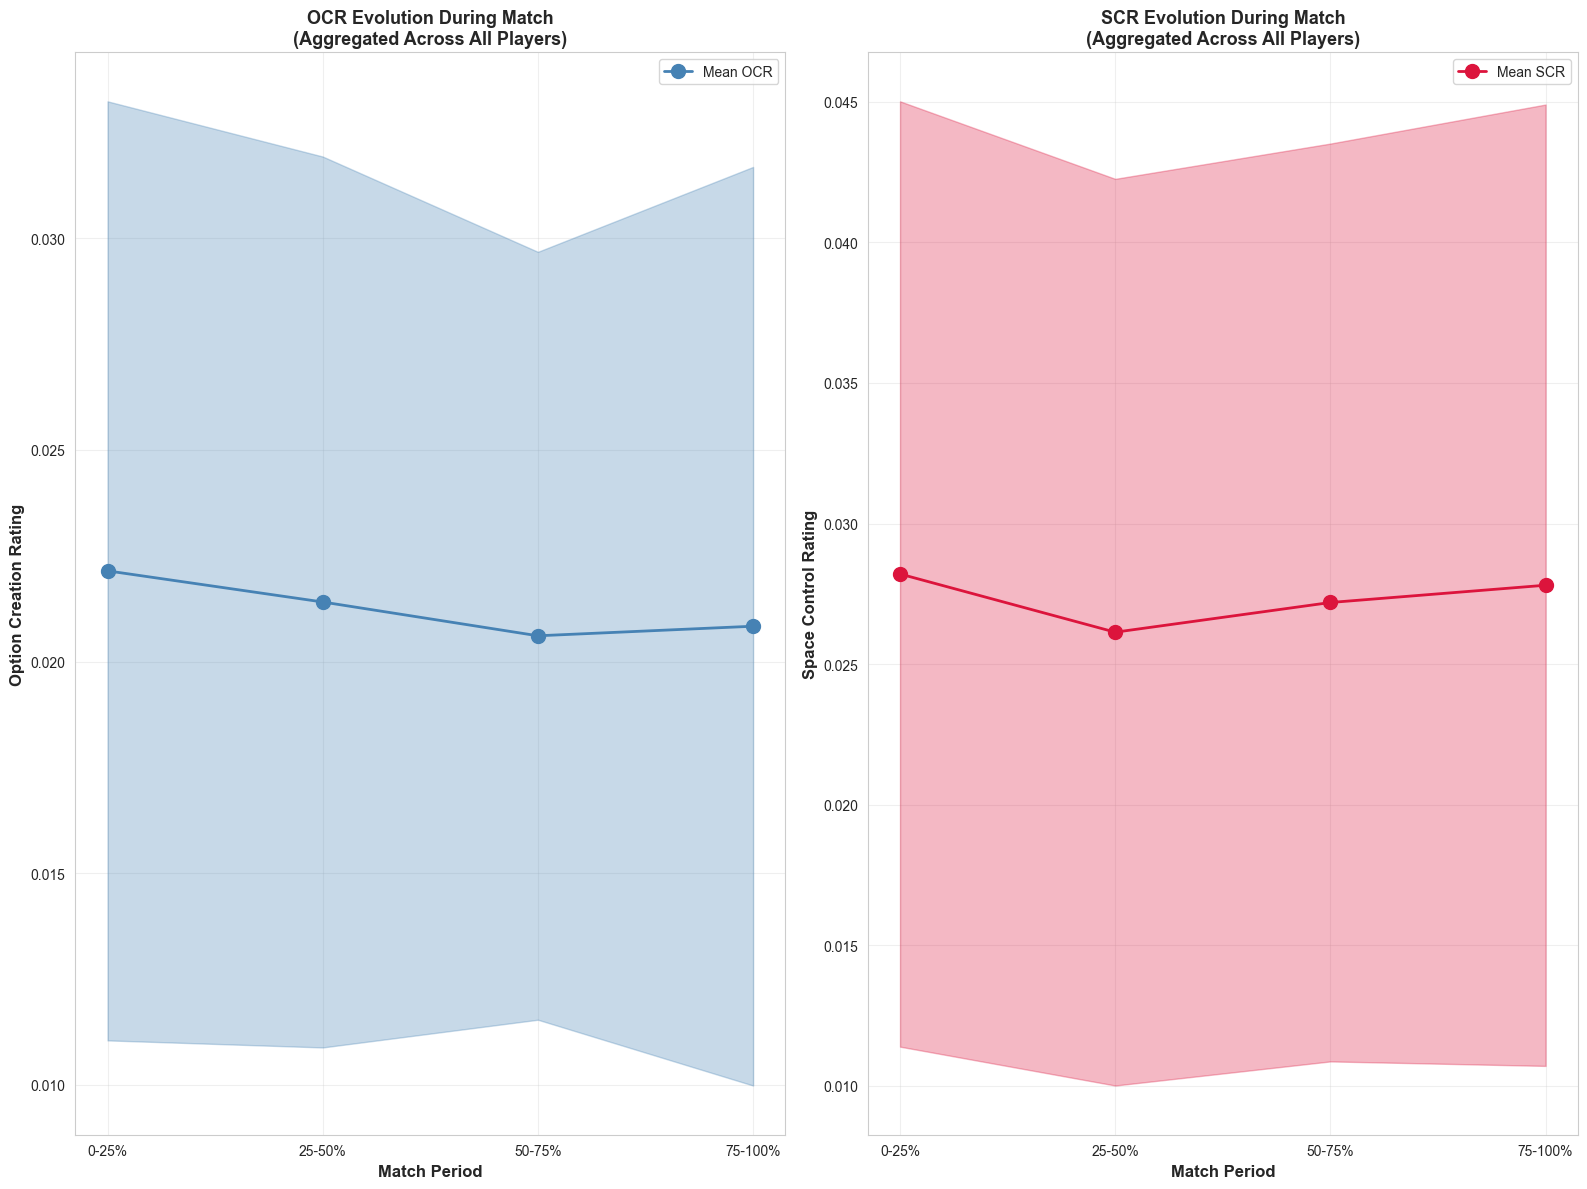

In [6]:
temporal_evolution = analyze_temporal_evolution(combined_df, match_seqs)